In [1]:
%matplotlib inline
from __future__ import division
from quantecon.lucas_search import LucasSearch
from quantecon.lucas_search_general import LucasSearchGeneral
import numpy as np
import matplotlib.pyplot as plt
from quantecon.compute_fp import compute_fixed_point

### Equilibrium Search and Unemployment - Robert Lucas and Edward Prescott - 1974



**The model**

Consider an *island economy*. There is a continuum of workers distributed among the islands. Each island contains a perfectly competitive industry that uses labor to produce their final good. Also, each island faces a stochastic demand.  
At each period, workers decide whether to stay and work in the island at the current wage, or move to another island. Moving out means not working in that period.  

Since the industry is competitive, wages must equal the marginal return of labor; which gives a labor demand function. As the labour demand depends on the stochastic demand of the final good, the labor demand function will be stochastic as well. At any time, the amount of labor demanded must be less than the number of workers in the island.


**Model Specifications**

```python
    class LucasSearch(object):
        def __init__(self, beta=.9, states=[1, 2], transition=[[.9, .1], [.1, .9]], lamb=3):
            self.beta = beta
            self.states = states
            self.transition = transition
            self.labour_demand = lambda n, s: (s/2)*(1-.01*n)
            self.grid = np.linspace(1, 100, 100)
            self.lamb = lamb
```
In order to compute the equilibrium, the labour space and the states of the demand have been discretized.  
As usual, **beta** is the discount factor and **transition** is the transition matrix for the states of demand.  
The labour demand function takes the form $R(s,\, n) = s/2\cdot(1-\frac{n}{100})$, where $n$ is the amount of labour employed and $s$ is the state of the demand.  
As this code is computing the *partial* equilibrium, $\lambda$ (**lamb** in the code) is exogenously given.

I selected the default values in order to replicate part of Figure 5 of the paper.

In [2]:
#Instantiating the model with the default specification
ls = LucasSearch()

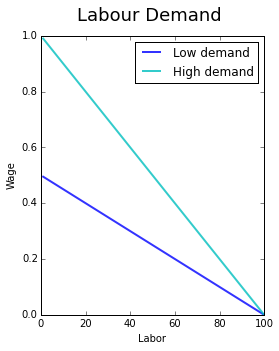

In [3]:
#Plotting the labour demand function
fig, ax = plt.subplots(figsize=(4,5))
ax.set_xlabel("Labor")
ax.set_ylabel("Wage")

wages = [[ls.labour_demand(n, s) for n in ls.grid] for s in ls.states]

ax.plot(ls.grid, wages[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, wages[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Labour Demand'
fig.suptitle(t, fontsize=18)

plt.show()

**Computing the value function**

I use the Bellman operator to solve for the following functional equation:  

$$ v(s,\, y,\, \lambda) = max[\lambda,\, R(s,\, n) + min(\lambda,\, \beta E[v(s',\, y',\, \lambda) | s,\, y,\, \lambda])] $$


```python
    def bellman_operator(self, v):
        Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(len(self.states))]
		Avx = lambda y: np.asarray([function(y) for function in Av]) 
        case_a = self.lamb
		
        Tv = np.asarray([np.empty(len(self.grid))]*len(self.states))
		for i, y in enumerate(self.grid):
			for j, state in enumerate(self.states):
				case_b1 = self.labour_demand(y, state) + self.beta*np.dot(self.transition[j], Avx(i))
                case_b2 = self.labour_demand(y, state) + self.lamb
				
				Tv[j][i] = max(case_a, min(case_b1, case_b2))
		return Tv
```

The value function takes the minimum of **case_b1** and **case_b2** because if the future value is too high, it will attract new workers from the rest of the economy until this excess value is wiped and this island is as good as the others. This means that $\lambda$ is an upper bound for how good a market's future can be.   
The value function takes the maximum of **case_a** and the rest because even if the situation of this island is grim, workers can move to other islands and get $\lambda$. In a similar manner, $\lambda$ is a lower bound for how bad an island's value can be. 


The following code plots the value function for a worker (not necessarily employed) that finds himself in an island with low/high demand and a workforce of size $y$.

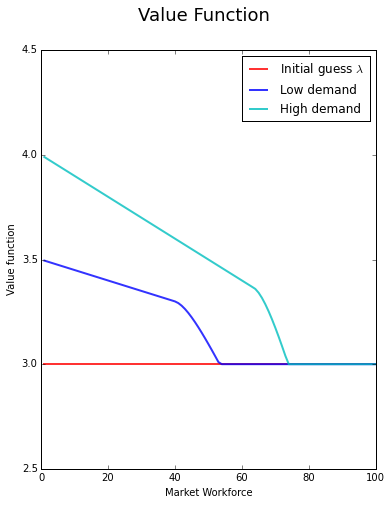

In [4]:
# Expected present value of the wage stream for a worker #
##########################################################

fig, ax = plt.subplots(figsize=(6,7.5))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Value function")
ax.set_ylim((2.5,4.5))
v = np.asarray([np.ones(len(ls.grid))*ls.lamb]*len(ls.states))
ax.plot(ls.grid, v[0], 'r-', lw = 2, alpha = .8, label=r'Initial guess $\lambda$')

v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
ax.plot(ls.grid, v_star[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, v_star[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right')

t = 'Value Function'
fig.suptitle(t, fontsize=18)

plt.show()

Clearly, there are three possibilities for the value function.  

At the right-hand side, the value function is equal to $\lambda$ and the island is in **Case A**. The island has a larger workforce than it requires. This means some workers are leaving and some remain.  

At the left-hand side, the market has a truly low workforce. The demand for labour is higher than the number of workers in the market. In the next period, this market would receive an influx of additional workers from other markets. This is what the authors call **Case B2**.  

At the middle, all the workers in the market are hired. However, unlike **Case B2**, the demand for labour is not so high as to entice outside workers to come to this market. This is what the authors call **Case B1**

**Calculating the Employment rate**

The number of employed workers when the value function is the entire workforce in **Case B1** and **Case B2**. 

However, in **Case A**, not all workers are hired. Since only the hired workers remain for the next period. This means:  

$$ v(s,\, y,\, \lambda) = R(s,\, n) + \beta E[v(s',\, n,\, \lambda) | s,\, y,\, \lambda] = \lambda$$

```python
    def compute_employment(self, v):
		Av = [InterpolatedUnivariateSpline(self.grid, v[i], k=3) for i in xrange(len(self.states))]
		Avx = lambda y: np.asarray([function(y) for function in Av])
		
		n_eq = np.asarray([np.empty(len(self.grid))]*len(self.states))
		
		function = [lambda n, s=state: self.labour_demand(n, s) + 
                                       self.beta*np.dot(self.transition[j], Avx(n)) 
                                       - self.lamb for j, state in enumerate(self.states)] 
			
		for j in xrange(len(self.states)):
			n_solve = fsolve(function[j], self.grid.max()/2) 
			n_eq[j] = np.ones(len(self.grid))*n_solve
			
		for i, y in enumerate(self.grid):
			for j in xrange(len(self.states)):
				n_eq[j][i] = min(n_eq[j][i], y)
		
		return n_eq

```

This function takes the value function and finds the $\widetilde{n}$ that solves the equation above. In particular, Python can achieve that by finding the zero in **function**.

This plot shows the number of employed workers in a market with a high/low state of demand and a workforce of size **y**.

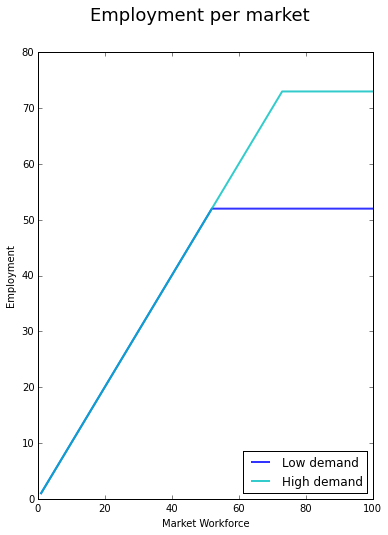

In [5]:
# Employment Plot #
###################

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Employment")

employment = ls.compute_employment(v_star)
#ax.plot(ls.grid, ls.grid, 'r-', lw = 2, alpha = .8, label = "Full employment")
ax.plot(ls.grid, employment[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, employment[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Employment per market'
fig.suptitle(t, fontsize=18)

plt.show()

As we have seen in the last plot, for large workforces (large values of **y**) only some of the workers will be hired.

**Why aren't the rest of the workers hired?**

For one, firms cannot hire more workers at the same wage as they are already hiring the optimal amount. The marginal value of labour is already equal to the wage, so hiring a new worker would increase the production by less than his wage. In order to hire more workers, the wage would have to be lower.

However, wages cannot decrease any further. If wages were any lower, workers would prefer to leave their employments and search for a job in a different island. 

In a nutshell, firms cannot hire more workers at current wages and wages cannot decrease because if they did, employees would rather go search for a job at a different market.

**Unemployment Plot**  
This plot shows the number of unemployed workers in a market with a high/low state of demand and a workforce of size **y**.

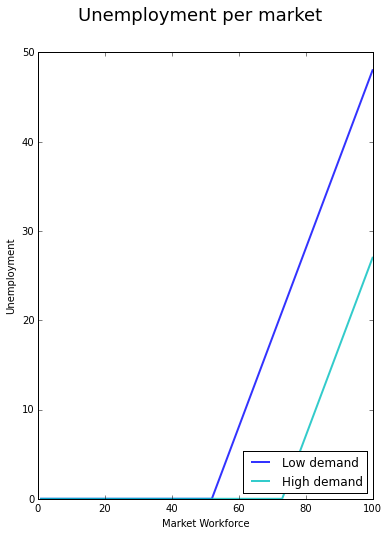

In [6]:
# Unemployment Plot #
#####################

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Unemployment")

unemployment= [ls.grid - employment[0], ls.grid - employment[1]] 

ax.plot(ls.grid, unemployment[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, unemployment[1], 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'lower right')

t = 'Unemployment per market'
fig.suptitle(t, fontsize=18)

plt.show()

This plot shows clearly how markets have an upper bound for the number of workers they can accomodate. Having a workforce that is larger than this upper bound means the excess workers will be unemployed.

**How does the value of search ($\lambda$) affect the amount of labor demanded?**

Since workers can either search for a job (in a different island) or accept their job offer; the value of search is a lower bound to the value of getting a job.  
In a traditional, Walrasian market, the value of search is zero (because workers cannot search for a job). In that case, the opportunity cost of getting a job for the worker is effectively zero. Thus, the wage $w$ will adjust as low as necessary, in order to accomodate the complete workforce.  

In this particular model, wages do have a lower bound. If wages were so low as to make the value of taking the job offer less than the value of search, no worker would take the job and the complete workforce would leave the island. Hardly an equilibirum outcome.  

Following this reasoning, a higher $\lambda$ lowers the amount of labor demanded in every particular island. 

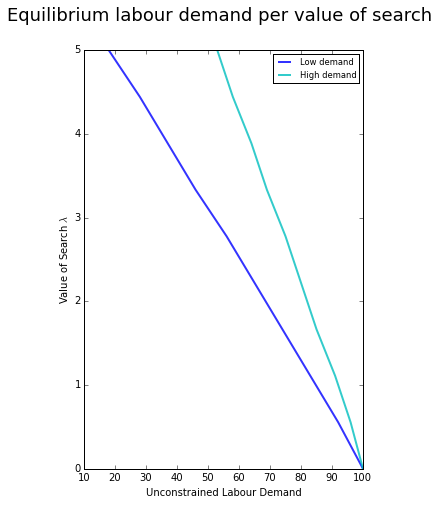

In [7]:
lambdas = np.linspace(0, 5, 10)
demand_high = np.empty(len(lambdas))
demand_low = np.empty(len(lambdas))

for i, lam in enumerate(lambdas):
    L = LucasSearch(lamb=lam)
    v = np.asarray([np.ones(len(L.grid))*L.lamb]*len(L.states))
    v_star = compute_fixed_point(L.bellman_operator, v, verbose=0)
    demand_low[i] = L.unconstrained_employment(v_star)[0]
    demand_high[i] = L.unconstrained_employment(v_star)[1]
    


fig, ax = plt.subplots(figsize=(5, 7.5))
ax.set_xlabel("Unconstrained Labour Demand")
ax.set_ylabel(r"Value of Search $\lambda$")

ax.plot(demand_low, lambdas, 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(demand_high, lambdas, 'c-', lw = 2, alpha = .8, label = "High demand")

ax.legend(loc = 'upper right', fontsize='small')

t = 'Equilibrium labour demand per value of search'
fig.suptitle(t, fontsize=18)

plt.show()

**Workforce in next period**

Let's assume (as the authors do) that unemployed workers are perfectly directed towards the markets that most need them.  

Markets with a small workforce (**Case B2**) receive enough workers such that the value of search is equal to the expected value of taking a job in that market taking into account the additional workers.  
Markets with a large workforce (**Case A**) keep only those workers that were hired.  
In **Case B1**, the workforce remains the same since there is no incentive for new workers to go to this market and the whole workforce is employed. 

```python
    def next_workforce(self, v):
		n_eq = self.compute_employment(v) #Calculates the number of employed workers
		next_wf = np.asarray([np.empty(len(self.grid))]*len(self.states)) 

		if stochastic:
			x = np.linspace(0, 2, 100) #x is a random variable following a uniform distribution between 0 and 2 
			fx = (1/len(x))*np.ones(len(x))
			def Avxx(y, a):
				""" 
				Computes the expected value of the value function using
				the predefined distribution.
				"""
				values = np.asarray([np.empty(len(self.states))]*len(x)) 
				for i, x_val in enumerate(x):
					values[i] = Avx(y + a*x_val)*fx[i]
				return values.sum(axis = 0)
				
		for j, state in enumerate(self.states):
			for i, y in enumerate(self.grid):
				if n_eq[j][i] == y: # This means we are in case B1 or B2
					if stochastic:
						e_value =[self.beta*np.dot(self.transition[j], Avxx(y, a)) < self.lamb for a in xrange(100)] 
					else:
						e_value =[self.beta*np.dot(self.transition[j], Avx(y + a)) < self.lamb for a in xrange(100)]
					
					try:
						a_star = e_value.index(True) # This function gives the first a for which the function
					except ValueError:
						a_star = 0				 	 # self.beta*np.dot(self.transition[j], Avx(y + a)) - self.lamb
												 	 # becomes negative. Thus, it is the (expected if stochastic)
												 	 # number of workers arriving in the next period. 
					next_wf[j][i] = y + a_star
				
				else: # This is case A 
					next_wf[j][i] = next_wf[j][i-1] #As no more workers are being hired, 
													#next period workforce is the same as 
													#for a market with one less worker 	
									
		return next_wf
```

The number of workers arriving is such that the value of the island after they arrive is as good as searching for other island. 
$$ \beta E_{s}[v(s',\, y + a*x,\, \lambda) | s,\, y,\, \lambda] = \lambda$$

If we assume there is randomness in the arrival to the island, the equation to satisfy is: 
$$ \beta E_{x}[\, E_{s}[v(s',\, y + a*x,\, \lambda) | s,\, y,\, \lambda]\,] = \lambda$$

$a$ is the number of incoming workers. 

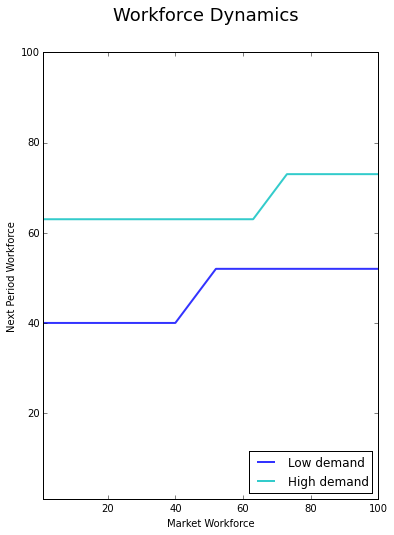

In [8]:
v = np.asarray([np.ones(len(ls.grid))*ls.lamb]*len(ls.states))
v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
new_wf = ls.next_workforce(v_star)

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Next Period Workforce")
ax.set_ylim((1,100))
ax.set_xlim((1,100))

ax.plot(ls.grid, new_wf[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, new_wf[1], 'c-', lw = 2, alpha = .8, label = "High demand")
#ax.plot(ls.grid, ls.grid, 'r-', lw = 2, alpha = .8, label = "Identity")

ax.legend(loc = 'lower right')

t = 'Workforce Dynamics'
fig.suptitle(t, fontsize=18)

plt.show()

This graph shows the transition between the size of the workforce for an island assuming no randomness in the process of moving to another island. 

For instance, let's say there is an island with 20 workers and low demand. Next period, about 20 more workers will go into the island for a total of about 40 workers. If in the next period, the state of demand changes from low to high; the period after that will have a little more than 60 workers, and so on.

It is easy to see that the workforce size will stay constant for as long as the state of demand stays the same and that it will go in a cycle when the state of demand changes. 

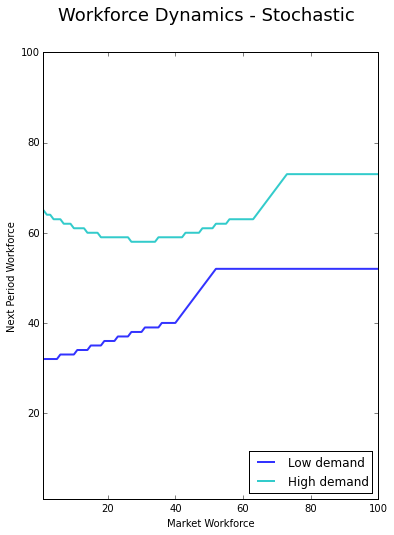

In [9]:
v = np.asarray([np.ones(len(ls.grid))*ls.lamb]*len(ls.states))
v_star = compute_fixed_point(ls.bellman_operator, v, verbose=0)
new_wf = ls.next_workforce(v_star, stochastic=True)

fig, ax = plt.subplots(figsize=(6,8))
ax.set_xlabel("Market Workforce")
ax.set_ylabel("Next Period Workforce")
ax.set_ylim((1,100))
ax.set_xlim((1,100))

ax.plot(ls.grid, new_wf[0], 'b-', lw = 2, alpha = .8, label = "Low demand")
ax.plot(ls.grid, new_wf[1], 'c-', lw = 2, alpha = .8, label = "High demand")
#ax.plot(ls.grid, ls.grid, 'r-', lw = 2, alpha = .8, label = "Identity")

ax.legend(loc = 'lower right')

t = 'Workforce Dynamics - Stochastic'
fig.suptitle(t, fontsize=18)

plt.show()

This graph is equivalent to the one above. The difference is the randomness of moving to an island. The model assumes that the workers know this.

The dynamics of the workforce could be described as a Markov Chain. It is possible to define a transition matrix that fully describes this process.

**Simulating the history of a given island**  

The following plot shows the simulated path for an economy

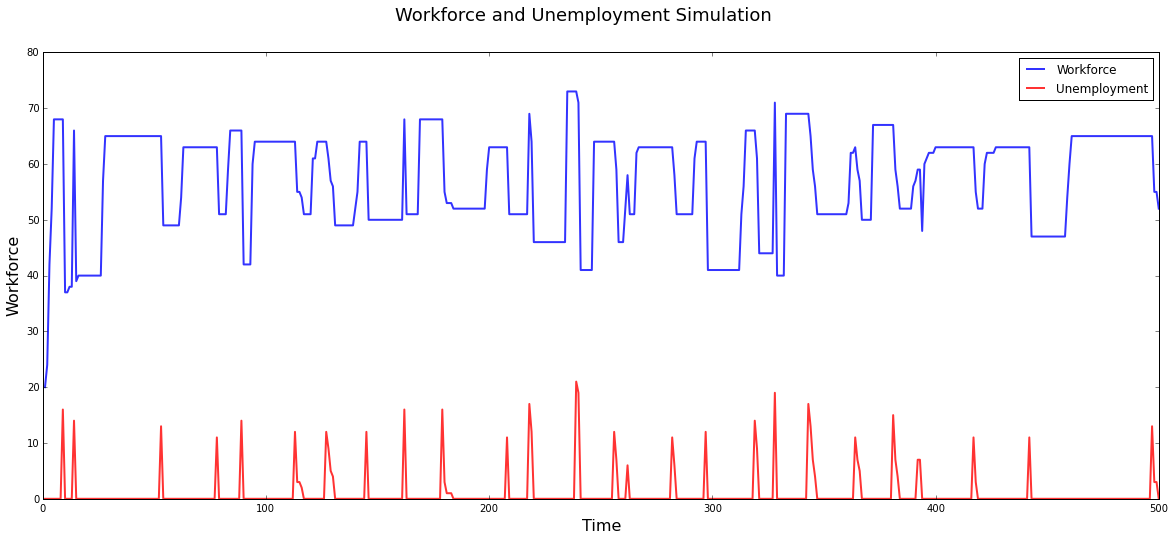

In [10]:
def next_wf(y, state):
    # Returns the next period workforce for an island
    # with workforce y and state of demand = state
    # This is the "element" version of the method next_workforce 
    return new_wf[state][list(ls.grid).index(y)]

employment = ls.compute_employment(v_star)
def unemployment(y, state):
    # Returns the number of unempployed for an island
    # with workforce y and state of demand = state
    return y - employment[state][list(ls.grid).index(y)]

#Initial Values
wf = 20 # starting workforce
T = 5000 # Number of periods
s = 0 # starting in a low demand state

#Initializing the arrays
wf_history = np.empty(T)
un_history = np.empty(T)
unrate_history = np.empty(T)

#Writing history
for i in xrange(T):
    wf_history[i] = wf
    un_history[i] = unemployment(wf, s)
    unrate_history[i] = 100*unemployment(wf, s)/wf
    wf = wf + int((next_wf(wf, s) - wf) * np.random.uniform(0, 2))
    s = np.random.choice(ls.states, p = ls.transition[s]) - 1
    
time = np.linspace(1, T, T)

#Plotting
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Workforce", fontsize = 16)

ax.plot(time[:500], wf_history[:500], 'b-', lw = 2, alpha = .8, label = "Workforce")
ax.plot(time[:500], un_history[:500], 'r-', lw = 2, alpha = .8, label = "Unemployment")


ax.legend(loc = 'upper right')

t = 'Workforce and Unemployment Simulation'
fig.suptitle(t, fontsize=18)

plt.show()

If a market starts with a low workforce, over time it attracts more workers. A market with a low workforce pays higher wages and that is the incentive for workers to go there.  
The fluctuations in the unemployment and the workforce size correspond to changes in the state of demand and the uncertainty in the arriving process. 

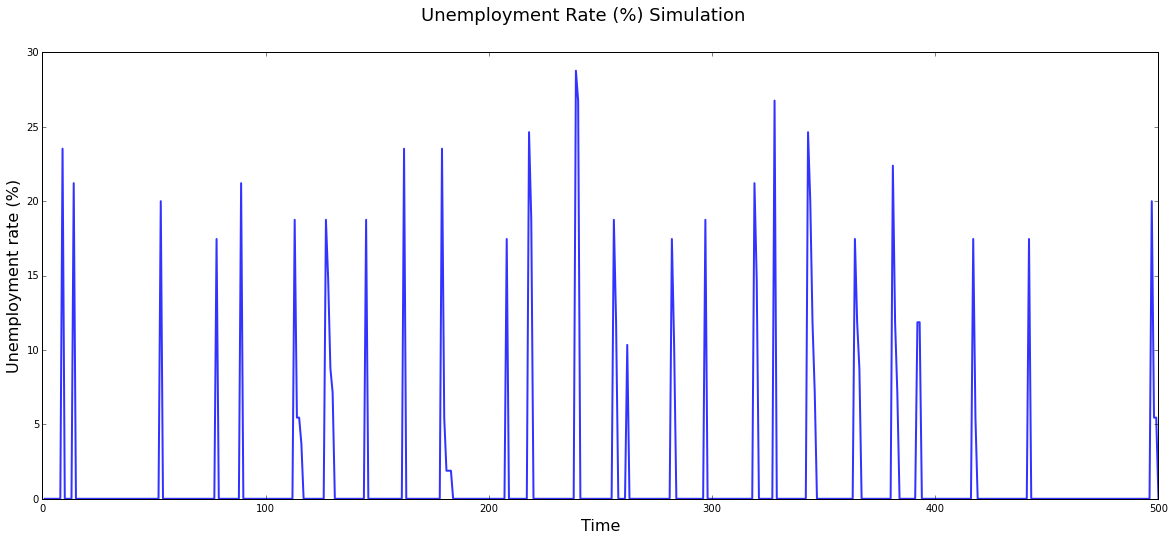

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment rate (%)", fontsize = 16)

ax.plot(time[:500], unrate_history[:500], 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate (%) Simulation'
fig.suptitle(t, fontsize=18)

plt.show()

In order to appreciate the economic cycles, we can look at the moving average of our simulated time series. The natural cycle of the economy between high and low states of demand and the randomness in the arriving process generate these fluctuations.

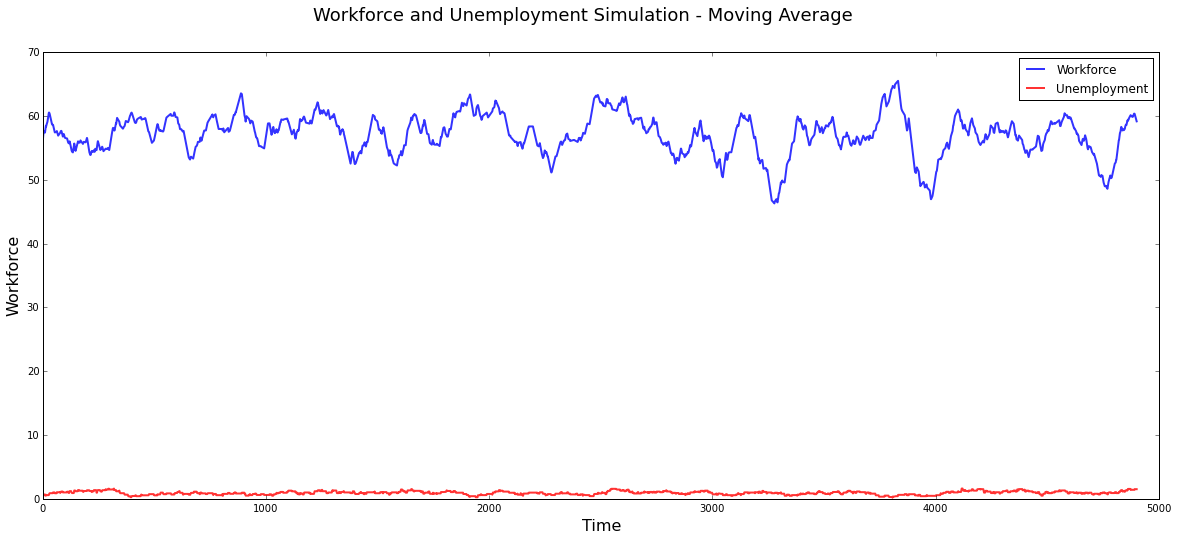

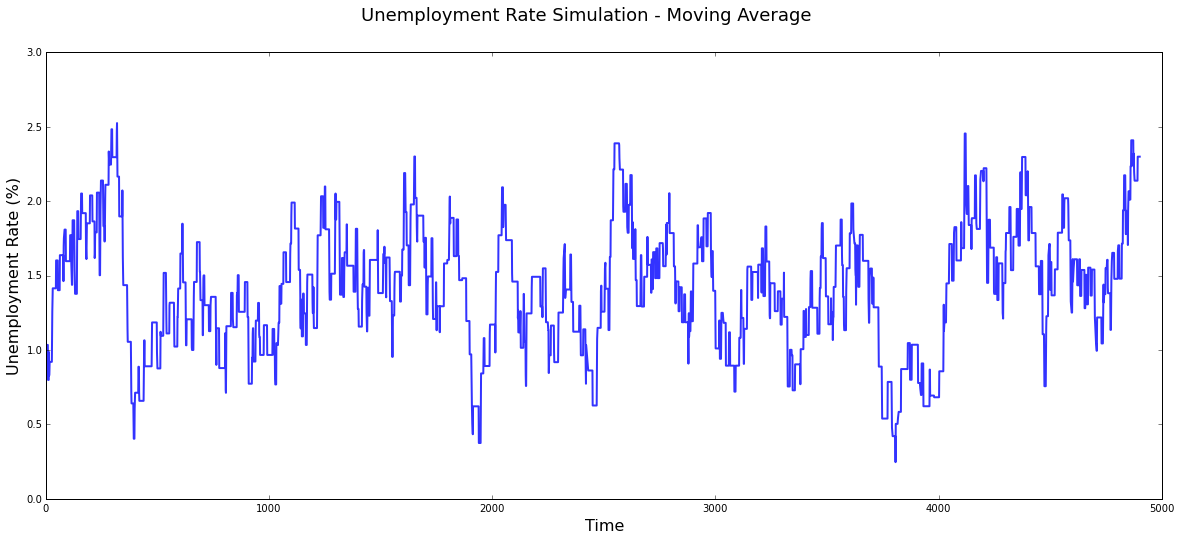

In [12]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

N = 100 # Number of periods for moving average

wf_history_ma = moving_average(wf_history, n=N)
un_history_ma = moving_average(un_history, n=N)
unrate_history_ma = moving_average(unrate_history, n=N)
time_ma = np.linspace(1, len(unrate_history_ma), len(unrate_history_ma))

#Plotting Workforce size and unemployyment
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Workforce", fontsize = 16)

ax.plot(time_ma, wf_history_ma, 'b-', lw = 2, alpha = .8, label = "Workforce")
ax.plot(time_ma, un_history_ma, 'r-', lw = 2, alpha = .8, label = "Unemployment")

ax.legend(loc = 'upper right')

t = 'Workforce and Unemployment Simulation - Moving Average'
fig.suptitle(t, fontsize=18)

plt.show()

#Plotting the unemployment rate
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment Rate (%)", fontsize = 16)

ax.plot(time_ma, unrate_history_ma, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate Simulation - Moving Average'
fig.suptitle(t, fontsize=18)

plt.show()

** Computing the economy equilibirium ** 

We have been calculating results for an individual island. In order to do that, we assumed the value of $\lambda$ as given.

However, the *value of search* is determined by the conditions of the economy. In an economy with a large number of workers, it's harder to find a job. Also, wages are likely to be lower as there is a lot of labor supply. Thus, the *value of search* should be lower in economies (not to be confused with islands) with a larger workforce. 

We can compute the *value of search* in two different ways.

First, taking advantage of the code written so far, we can compute the average workforce associated with a particular *value of search*. 

Then, for an economy with a given average workforce size per island, we can find the equilibirum *value of search* ($\lambda$) by looking at the corresponding value in the relation established above.

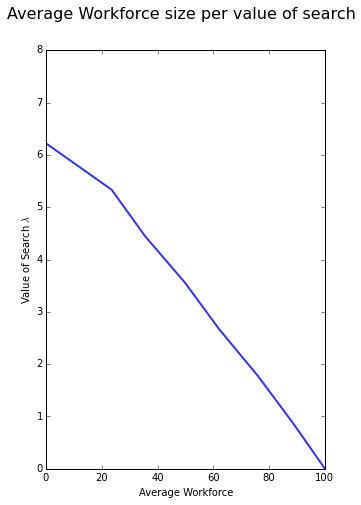

In [13]:
lambdas = np.linspace(1e-3, 8, 10)
horizon = 5000

workforce_mean = np.empty(len(lambdas))

for i, lam in enumerate(lambdas):
    L = LucasSearch(lamb=lam)
    wf = np.linspace(1, 100, 100)
    v = np.asarray([np.zeros(len(L.grid))]*len(L.states))
    v_star = compute_fixed_point(L.bellman_operator, v, verbose=0, max_iter=30)
    new_wf = L.next_workforce(v_star, stochastic=False)
    
    for j in xrange(horizon):
        states = np.random.randint(2, size=len(wf))
        wf = [new_wf[states[k]][list(L.grid).index(y)] if y!= 0 else 0 for k, y in enumerate(wf)] 
        change = np.random.choice((0,1), p=(.9, .1), size=len(wf)) # 1 if the state changes, 0 otherwise
        states = (states + change)%2 # Computes the new state

    workforce_mean[i] = np.asarray(wf).mean()

#Plotting
fig, ax = plt.subplots(figsize=(5, 7.5))
ax.set_xlabel("Average Workforce")
ax.set_ylabel(r"Value of Search $\lambda$")

ax.plot(workforce_mean, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Workforce size per value of search'
fig.suptitle(t, fontsize=16)

plt.show()

Now, we can say that an economy with an average workforce size of 40 will have a *value of search* approximately equal to 4.

This form of calculating $\lambda$ depends on a crucial assumption. The assumption is that the number of islands in the economy is really large. It has to be large enough (a continuum) so that even though islands face a stochastic demand, the aggregate demand of the economy is constant.

If this assumption failed and the aggregate demand were to be stochastic, then $\lambda$ should change to reflect this. A lower aggregate demand should be associated with a lower *value of search*. 

The second way to compute the value of search is not based on the assumption of a continuum of islands. However, it requires us to specify the number of islands and the number of workers per island. 

The following code computes the value of lambda for an arbitrary economy. An economy is defined as a group of islands and each island is defined by its workforce (the number of workers) and its state of demand. 

```python
class LucasSearchGeneral(object):

    def __init__(self, beta=.9, states=[1, 2], transition=[[.9, .1], [.1, .9]], 
					islands_wf = [50]*100, islands_state = [0]*50 + [1]*50,
					stochastic=False): 
	
        self.beta = beta
		self.states = states
		self.transition = transition
		self.islands_wf = islands_wf
		self.islands_state = islands_state
		self.stochastic = stochastic
```

The model needs a complete specification of the economy. That is a workforce and state of demand for each island. 

Since we assume a fixed number of workers in the economy. The equilibrium *value of search* in a given period is such that the net change in workforce in the economy is zero. 

We could easily simulate an economy with an increasing workforce. We would need to establish that the equilibrium *value of search* makes the net change in workforce be positive and equal to the workforce rate of growth. 

```python
    def net_moves(self, l):
		wf_change = LucasSearch(beta=self.beta, states=self.states,
                                    transition=self.transition,lamb=l).workforce_change(stochastic=self.stochastic)
                                    
		return np.asarray([wf_change[state][y] for state, y in izip(self.islands_state, self.islands_wf)]).sum()
```

The function **net_moves** takes as argument a possible *value of search* ($\lambda$) and, assuming that particular value, computes the change in the workforce for each of the islands. 

The equilibirum *value of search* ($\lambda^{*}$) satisfies $\text{net_moves}(self,\, l \, = \, \lambda^{*}) = 0 $  

```python
    def get_lambda(self):
  
        change = lambda l: self.net_moves(l)
		lambda_star = brenth(change, 0, 10)
		return lambda_star
```

$\lambda$ could be found using a typical (non-linear) equation solving algorithm. **brenth** is an application of Brent's method, which is a combination of the bisection method, the secant method and inverse quadratic interpolaton.    



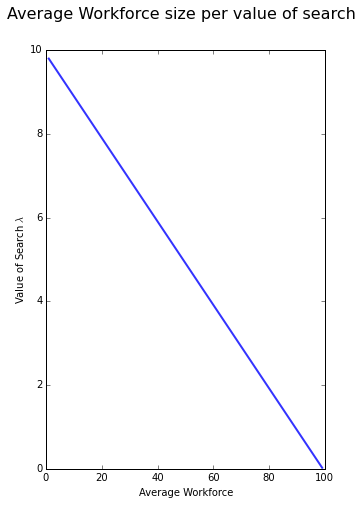

In [14]:
avg = np.linspace(1, 99, 2)
number_of_islands = 100000
number_high_demand = int(.5*number_of_islands)

lambdas = [LucasSearchGeneral(islands_wf=[average_workforce]*number_of_islands, 
                              islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand)).get_lambda() 
                               for average_workforce in avg]

fig, ax = plt.subplots(figsize=(5, 7.5))
ax.set_xlabel("Average Workforce")
ax.set_ylabel(r"Value of Search $\lambda$")

ax.plot(avg, lambdas, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right', fontsize='small')

t = 'Average Workforce size per value of search'
fig.suptitle(t, fontsize=16)

plt.show()

We should take into account that $\lambda$ not only depends on the aggregate state of demand but also on the distribution of workers across the islands. For the plot above, we calculated the *value of search* for an economy with the same workforce in each island. Evidently, some workers need to be reallocated in this economy. 

**Simulating the complete economy**

Now that we have a way to simulate the dynamics of any island economy. 

This simulation is for an economy with 100 islands and an average of 45 workers per island. As starting point, islands have the same number of workers and half of them are in a high demand state. This simulation supposes a deterministic arrival process. 


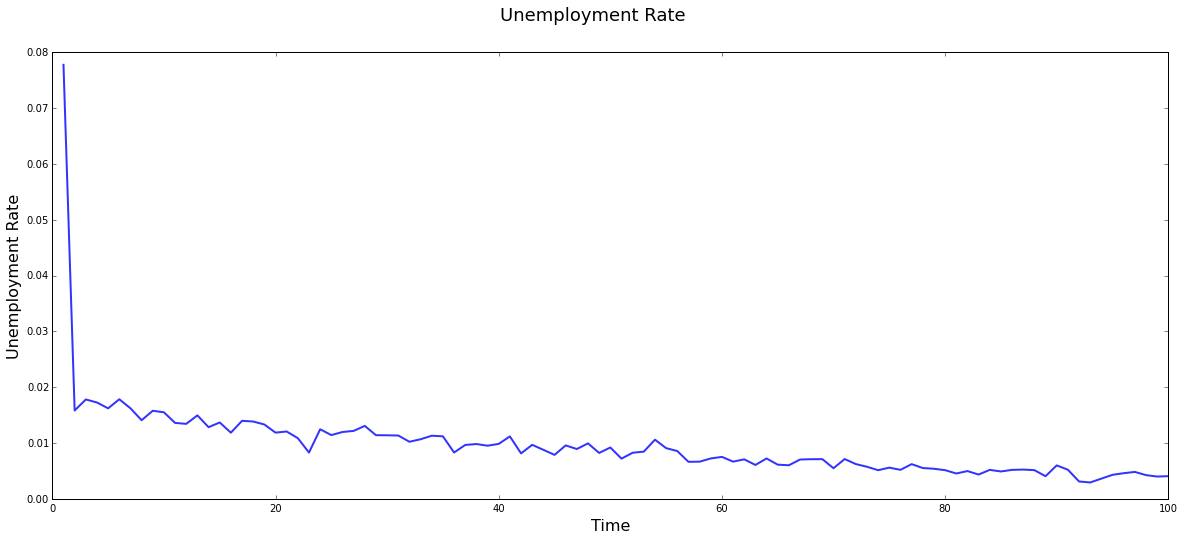

In [15]:
number_of_islands = 1000
average_workforce = 45
number_high_demand = int(.5*number_of_islands)

#LSG = LucasSearchGeneral(islands_wf=[37]*(number_of_islands-number_high_demand) + [53]*(number_high_demand), 
#                         islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand))

LSG = LucasSearchGeneral(islands_wf=[average_workforce]*(number_of_islands), 
                         islands_state=[0]*(number_of_islands-number_high_demand)+[1]*(number_high_demand))
t = 100
time = np.linspace(1,t,t)
l, s, u = LSG.simulate(T=t, compute_unemployment=True) 

#Plotting the Unemployment Rate
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Unemployment Rate", fontsize = 16)

ax.plot(time, u, 'b-', lw = 2, alpha = .8)

ax.legend(loc = 'upper right')

t = 'Unemployment Rate'
fig.suptitle(t, fontsize=18)

plt.show()


We can observe the level of unemployment never getting to zero. Since at any given time, some islands' state of demand is changing and the workers in those islands need to reallocate.  

We can also plot the *value of search* and the average state of demand of the economy. 

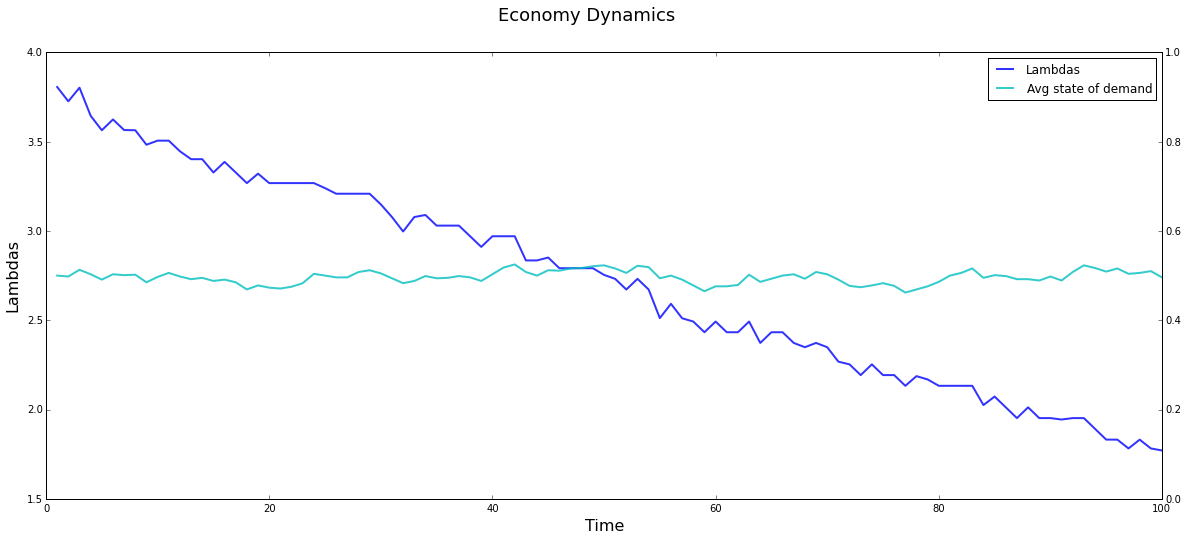

Correlation state of demand and value of search: 0.0034


In [16]:
#Plotting the dynamics of lambda and the state of demand
fig, ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Lambdas", fontsize = 16)
#ax.set_ylim(2,6)
ax2.set_ylim(0,1)
plot1 = ax.plot(time, l, 'b-', lw = 2, alpha = .8, label="Lambdas")
plot2 = ax2.plot(time, s, 'c-', lw=2, alpha=.8, label="Avg state of demand")

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper right')

t = 'Economy Dynamics'
fig.suptitle(t, fontsize=18)

plt.show()

## Correlation
print r"Correlation state of demand and value of search: {0:.2g}".format(np.corrcoef(l,s)[0,1])

The relationship between these two variables is not very clear. However, if we look at the first difference time series, the relationship becomes evident.

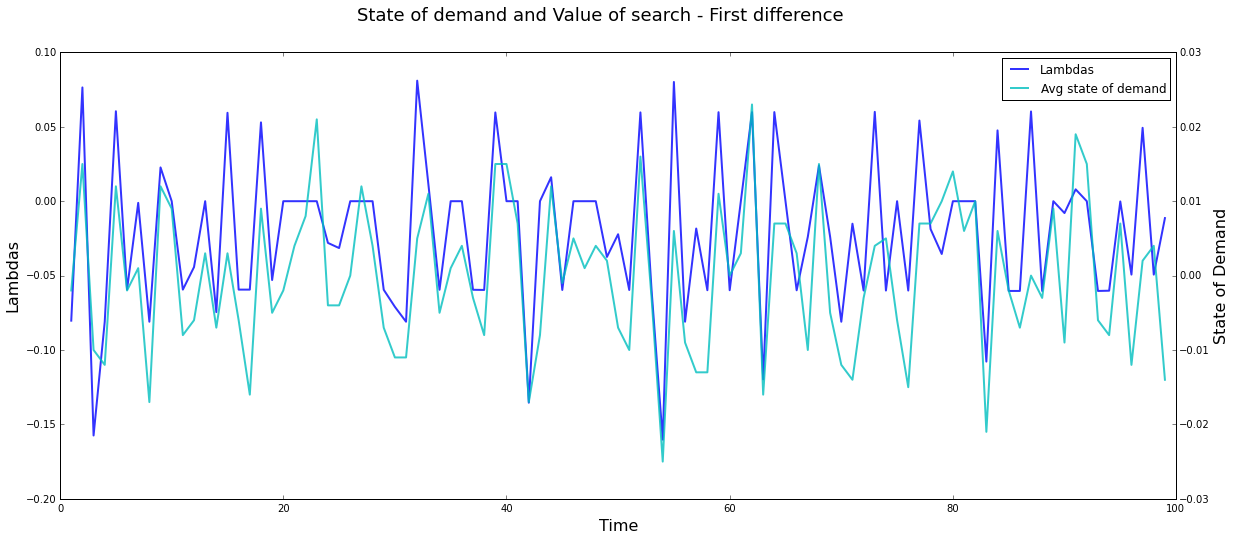

Correlation state of demand and value of search - First difference: 0.73


In [17]:
#Plotting the dynamics of lambda and the state of demand. First Difference.
dl = [l[i] -l[i-1] for i in xrange(1,len(l))]
ds = [s[i] -s[i-1] for i in xrange(1,len(s))]
time2 = np.linspace(1, len(dl), len(dl))

fig, ax = plt.subplots(figsize=(20,8))
ax2 = ax.twinx()
ax.set_xlabel("Time", fontsize = 16)
ax.set_ylabel("Lambdas", fontsize = 16)
ax2.set_ylabel("State of Demand", fontsize = 16)

plot1 = ax.plot(time2, dl, 'b-', lw = 2, alpha = .8, label="Lambdas")
plot2 = ax2.plot(time2, ds, 'c-', lw=2, alpha=.8, label="Avg state of demand")

plots = plot1 + plot2
labels = [p.get_label() for p in plots]
ax.legend(plots, labels, loc = 'upper right')

t = 'State of demand and Value of search - First difference'
fig.suptitle(t, fontsize=18)

plt.show()

##Correlation
print r"Correlation state of demand and value of search - First difference: {0:.2g}".format(np.corrcoef(dl,ds)[0,1])

As predicted above, when the economy's aggregate demand rises, the *value of search* rises as well. 

The *value of search* $\lambda$ captures the incentives workers have to leave an island and search for a job. These incentives are lower when the aggregate demand is low and higher when the aggregate demand is high.